In [1]:
# Import Liblary yang akan digunakan
import os
import Augmentor
import zipfile
import random
import zipfile
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [ ]:
def AugmentData(source_dir, count):
    source_dir = source_dir
    output_dir = "."
    p = Augmentor.Pipeline(source_directory=source_dir, output_directory=output_dir)
    #p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=1)
    p.rotate(probability=0.001, max_left_rotation=0.001, max_right_rotation=0.001)
    #p.zoom_random(probability=0.5, percentage_area=0.9)
    #p.crop_random(probability=0.6, percentage_area=0.9)
    #p.resize(probability=1.0, width=64, height=64)
    p.sample(count)

In [ ]:
AugmentData("Dataset 2/Gigi/", 1000)

In [ ]:
AugmentData("Dataset 2/Bukan Gigi/", 1000)

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


Gigi_SOURCE_DIR = "Dataset 2/Gigi/"
BukanGigi_SOURCE_DIR = "Dataset 2/Bukan Gigi/"

TRAINING_Gigi_DIR = "Dataset_Real 2/training/Gigi/"
TRAINING_BukanGigi_DIR = "Dataset_Real 2/training/Bukan Gigi/"

TESTING_Gigi_DIR = "Dataset_Real 2/testing/Gigi/"
TESTING_BukanGigi_DIR = "Dataset_Real 2/testing/Bukan Gigi/"

split_size = .8
split_data(Gigi_SOURCE_DIR, TRAINING_Gigi_DIR, TESTING_Gigi_DIR, split_size)
split_data(BukanGigi_SOURCE_DIR, TRAINING_BukanGigi_DIR, TESTING_BukanGigi_DIR, split_size)

In [36]:
TRAINING_DIR = "Dataset_Real 2/training/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "Dataset_Real 2/testing/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=10,
                                                              class_mode='binary',
                                                              target_size=(150, 150))


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
dim = (150, 150)
channel = (3, )
input_shape = dim + channel

def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

train_data = tf_data_generator(train_generator, input_shape)
validation_data = tf_data_generator(validation_generator, input_shape)

In [37]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 64)      

In [38]:
model.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(learning_rate=0.0001), 
              metrics=['accuracy'])

In [39]:
# Note that this may take some time.
history = model.fit(train_generator,
                    steps_per_epoch=40,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps=20)

Epoch 1/15
40/40 [==============================] - 4s 98ms/step - loss: 0.2475 - accuracy: 0.9062 - val_loss: 0.1302 - val_accuracy: 0.9500
Epoch 2/15
40/40 [==============================] - 4s 95ms/step - loss: 0.0846 - accuracy: 0.9712 - val_loss: 0.4538 - val_accuracy: 0.8450
Epoch 3/15
40/40 [==============================] - 4s 98ms/step - loss: 0.0870 - accuracy: 0.9638 - val_loss: 0.0268 - val_accuracy: 0.9900
Epoch 4/15
40/40 [==============================] - 4s 96ms/step - loss: 0.0488 - accuracy: 0.9875 - val_loss: 0.0584 - val_accuracy: 0.9850
Epoch 5/15
40/40 [==============================] - 4s 97ms/step - loss: 0.0533 - accuracy: 0.9762 - val_loss: 0.0788 - val_accuracy: 0.9750
Epoch 6/15
40/40 [==============================] - 4s 95ms/step - loss: 0.0660 - accuracy: 0.9800 - val_loss: 0.0387 - val_accuracy: 0.9850
Epoch 7/15
40/40 [==============================] - 4s 99ms/step - loss: 0.0590 - accuracy: 0.9825 - val_loss: 0.0517 - val_accuracy: 0.9800
Epoch 8/15
40

In [40]:
model.evaluate(validation_generator)

40/40 [==============================] - 2s 38ms/step - loss: 0.0207 - accuracy: 0.9950


[0.02069869078695774, 0.9950000047683716]

In [41]:
#classes 
class_names =  ["Gigi", "Bukan Gigi"]
for i in range(len(class_names)):
    print(class_names[i] ," " , i)

Gigi   0
Bukan Gigi   1


[1.]
1.jpgadalah gigi


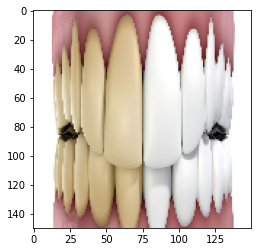

In [44]:
path = "1.jpg"
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0.5:
    print(path + " adalah gigi")
else:
    print(path + " bukan gigi")
    
plt.imshow(img)

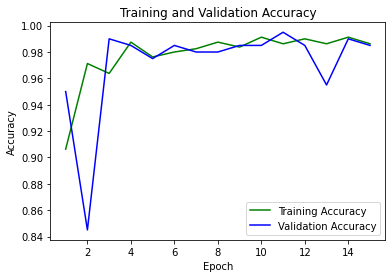

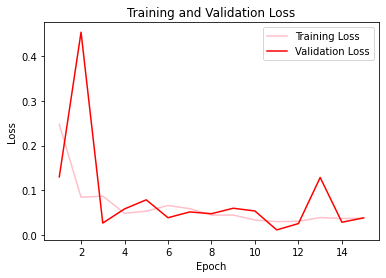

In [45]:
#plotting training values

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [46]:
export_dir = 'saved_model/1 - Gigi Bukan Gigi/'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1 - Gigi Bukan Gigi/assets


In [47]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [48]:
tflite_model_file = pathlib.Path('./model-gigiBukanGigi.tflite')
tflite_model_file.write_bytes(tflite_model)

38112900

In [49]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [50]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [53]:
image_path = "bukan_gigi 2.jpg"
new_img = image.load_img(image_path, target_size=(150, 150))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)

interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()
rflite_results = interpreter.get_tensor(output_details[0]['index'])

In [54]:
print(rflite_results)

[[0.]]
